# Transformer (PatchTST)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
print(sm.datasets.sunspots.NOTE)
data = sm.datasets.sunspots.load_pandas().data

data.index = pd.Index(sm.tsa.datetools.dates_from_range("1700", "2008"))
data.index.freq = data.index.inferred_freq
del data["YEAR"]

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



In [3]:
class TimeSeriesDataset(torch.utils.data.Dataset):
  def __init__(self, ts:np.array, patch_size:int=4, n_token:int=6):
    self.patch_size = patch_size
    self.n_patch = 4
    self.n_token = n_token
    self.window_size = int(patch_size * self.n_patch * n_token / 2)
    self.forecast_size = patch_size
    self.data = ts

  def __len__(self):
    return len(self.data) - self.window_size - self.forecast_size + 1

  def __getitem__(self, i):
    look_back = self.data[i:(i+self.window_size)]
    look_back = np.concatenate([look_back] + [look_back[-self.patch_size:]] * int(self.n_patch / 2))
    x = np.array([look_back[i*int(self.patch_size*self.n_patch/2):(i+2)*int(self.patch_size*self.n_patch/2)] for i in range(self.n_token)])

    y = self.data[(i+self.window_size):(i+self.window_size+self.forecast_size)]
    return x, y

In [4]:
4 * 4 * 6/2

48.0

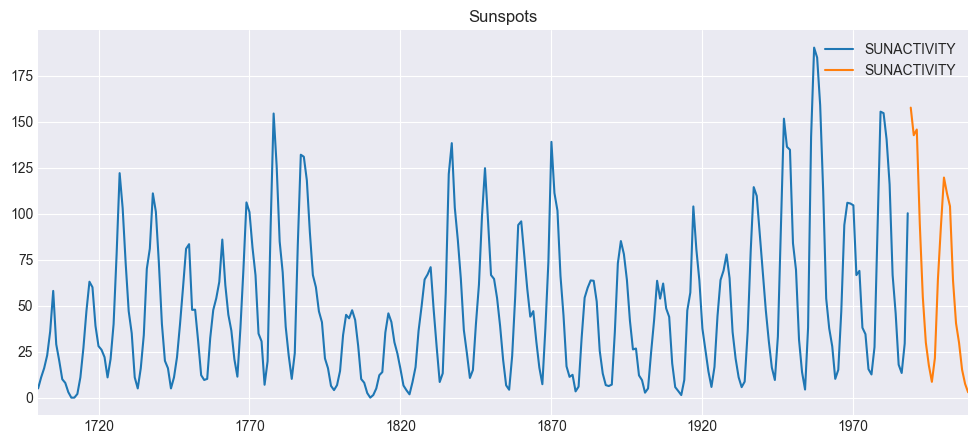

In [5]:
patch_size, n_patch, n_token = 4, 4, 6
window_size = int(patch_size * n_patch * n_token / 2)
tst_size = 20
trn, tst = data[:-tst_size], data[-tst_size:]

ax = trn.plot(title="Sunspots", label='trn', figsize=(12,5))
tst.plot(label='tst', ax=ax)
plt.legend()
plt.show()

In [6]:
trn_ds = TimeSeriesDataset(data.SUNACTIVITY.to_numpy(dtype=np.float32)[:-tst_size], 4, 6)
tst_ds = TimeSeriesDataset(data.SUNACTIVITY.to_numpy(dtype=np.float32)[-tst_size-window_size:], 4, 6)

trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size=32, shuffle=True)
tst_dl = torch.utils.data.DataLoader(tst_ds, batch_size=tst_size, shuffle=False)

In [7]:
x, y = next(iter(trn_dl))
x.shape, y.shape

(torch.Size([32, 6, 16]), torch.Size([32, 4]))

In [8]:
class PatchTST(nn.Module):
    def __init__(self, n_token, input_dim, model_dim, num_heads, num_layers, output_dim):
        super(PatchTST, self).__init__()
        self.patch_embedding = nn.Linear(input_dim, model_dim)    # Input Embedding
        self._pos = torch.nn.Parameter(torch.randn(1,1,model_dim))  # Positional Embedding

        encoder_layers = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        self.output_layer = nn.Linear(model_dim * n_token, output_dim)

    def forward(self, x):
        # x shape: (batch_size, n_token, token_size)
        x = self.patch_embedding(x)   # (batch_size, n_token, model_dim)
        x = x + self._pos
        x = self.transformer_encoder(x)   # (batch_size, n_token, model_dim)
        x = x.view(x.size(0), -1)       # (batch_size, n_token * model_dim)
        output = self.output_layer(x)   # (batch_size, out_dim =4 patch_size == 4)
        return output

In [9]:
from tqdm.auto import trange

model = PatchTST(n_token, patch_size * n_patch, 512, 8, 4, patch_size)
model.cuda()

optim = torch.optim.AdamW(model.parameters(), lr=0.0001)

pbar = trange(500)
for _ in pbar:
  model.train()
  total_loss = 0.
  for x,y in trn_dl:
    x, y = x.cuda(), y.cuda()
    p = model(x)
    optim.zero_grad()
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    total_loss += loss.item()*len(x)
  pbar.set_postfix({'loss': total_loss/len(trn_ds)})

  0%|          | 0/500 [00:00<?, ?it/s]

In [10]:
def mape(input, target):
  return (torch.abs(input - target)/target).mean() * 100

def mae(input, target):
  return torch.abs(input - target).mean()

In [11]:
model.eval()
x,y = next(iter(tst_dl))
x,y = x.cuda(), y.cuda()
with torch.inference_mode():
  p = model(x)

p = torch.concat([p[:,0],p[-1,1:]])
y = torch.concat([y[:,0],y[-1,1:]])
mape(p,y), mae(p,y)

(tensor(50.7825, device='cuda:0'), tensor(10.8149, device='cuda:0'))

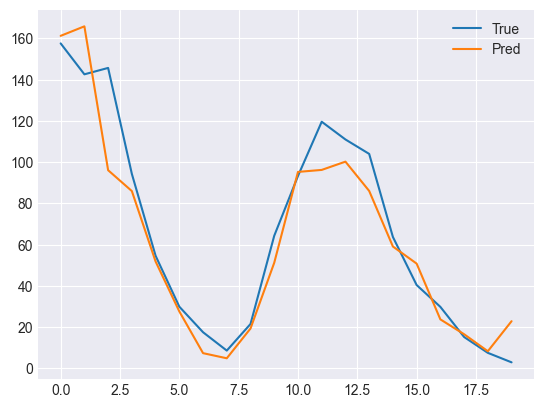

In [12]:
plt.plot(range(tst_size), y.cpu(), label='True')
plt.plot(range(tst_size), p.cpu(), label='Pred')
plt.legend()
plt.show()